# Aninmal Shelter - Dog Classification

In [2]:
# Imports
import pandas as pd
import random
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split

## Data Preparation

In [3]:
labels_path = '/kaggle/input/dog-breed-identification/labels.csv'
labels=pd.read_csv(labels_path)

In [4]:
# List of filenames
image_dir = '/kaggle/input/dog-breed-identification/train/'
filenames = [os.path.join(image_dir, f"{fname}.jpg") for fname in labels['id']]


# Check if any files do not exist
missing_files = [fname for fname in filenames if not os.path.isfile(fname)]
print(f"Missing files: {len(missing_files)}")

Missing files: 0


In [5]:
# Set variables
X = filenames
y = labels['breed']

In [6]:
# One Hot Encode
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(labels[['breed']])
encoding_labels = encoder.categories_[0]

In [7]:
# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

# Subset for building
X_train_subset = X_train[:1000]
X_val_subset = X_val[:1000]

## Preprocessing Images

In [8]:
# Parameters for image and batch size
IMG_SIZE = 224
BATCH_SIZE = 32

# PyTorch image transforms - creates a preprocessing pipeline
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)), #resizes all the images
    transforms.ToTensor(), #converts to tensorflow images
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # converts 0-1 to -1 to 1
])
# Get number of classes
num_classes = len(encoding_labels)

In [9]:
# PyTorch Dataset class
class DogBreedDataset(Dataset):
    #constructor
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
      #determines the length of the dataset
    def __len__(self):
        return len(self.image_paths)
    #called by PyTorch to get a specific item
    def __getitem__(self, idx):
        # Load and process image
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        # Return image and label
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return image, label
        

In [10]:
# Convert breed names to numbers
label_encoder = LabelEncoder()
y_train_subset_encoded = label_encoder.fit_transform(y_train[:1000])
y_val_subset_encoded = label_encoder.transform(y_val[:1000])

print(f"Number of classes: {len(label_encoder.classes_)}")

Number of classes: 120


In [11]:
# Create PyTorch datasets and dataloaders
def create_data_loaders(X_train, y_train, X_val, y_val, batch_size=BATCH_SIZE):
    #Create PyTorch DataLoaders for training and validation"""
    
    # Create datasets
    train_dataset = DogBreedDataset(X_train, y_train, transform)
    val_dataset = DogBreedDataset(X_val, y_val, transform)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    return train_loader, val_loader, train_dataset, val_dataset

In [12]:
# Create PyTorch DataLoaders

# Create training and validation data loaders
train_loader, val_loader, train_dataset, val_dataset = create_data_loaders(
    X_train_subset, 
    y_train_subset_encoded, 
    X_val_subset, 
    y_val_subset_encoded,
    batch_size=BATCH_SIZE
)

# Verify everything is working
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Number of classes: {num_classes}")
print(f"Batch size: {BATCH_SIZE}")

Training samples: 1000
Validation samples: 1000
Number of classes: 120
Batch size: 32


Total classes: 120
breed
scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
Name: count, dtype: int64


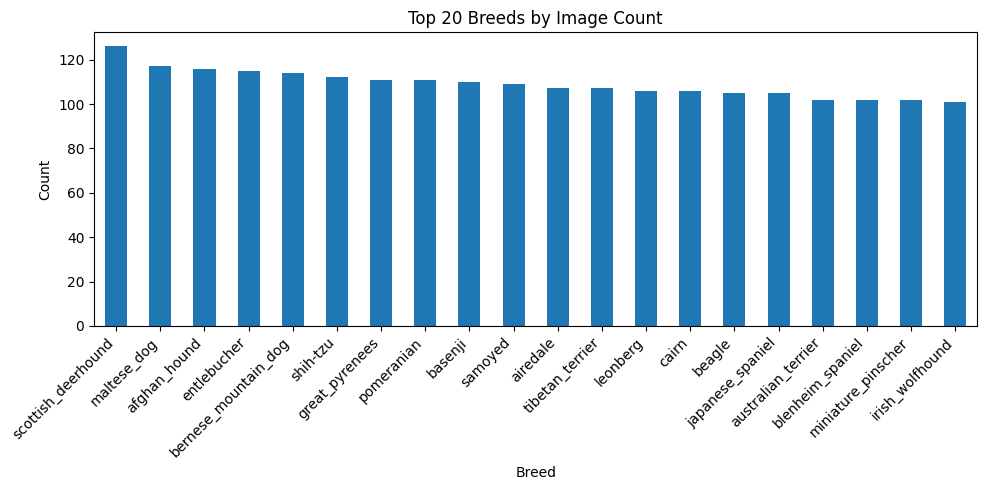

In [13]:
class_counts = labels['breed'].value_counts()
print(f"Total classes: {class_counts.shape[0]}")
print(class_counts.head())

plt.figure(figsize=(10,5))
class_counts.head(20).plot(kind='bar')
plt.title("Top 20 Breeds by Image Count")
plt.xlabel("Breed")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Found 10222 existing image files
Sampled 300 images.
Width : mean=440.7, std=184.8, min=112, max=2135
Height: mean=390.5, std=149.8, min=120, max=1720


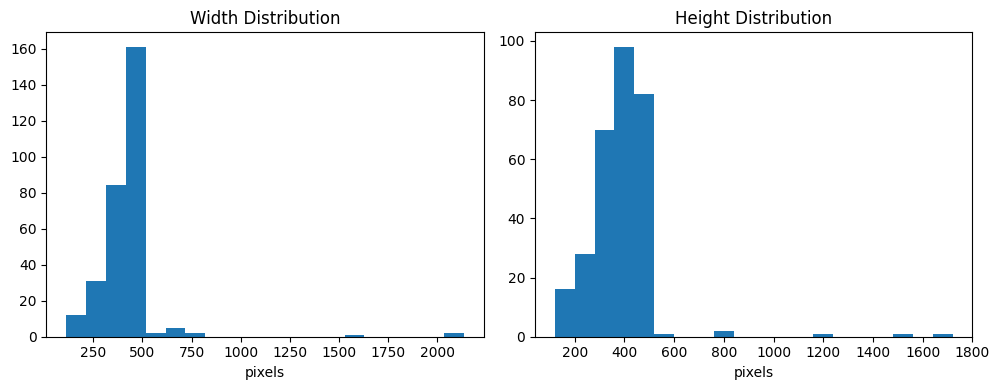

In [14]:
random.seed(42)

existing_files = [f for f in filenames if os.path.exists(f)]
print(f"Found {len(existing_files)} existing image files")

sample_paths = random.sample(existing_files, k=min(300, len(existing_files)))
wh = []

for p in sample_paths:
    try:
        with Image.open(p) as im:
            wh.append(im.size)  # (width, height)
    except Exception as e:
        pass

wh = np.array(wh)

# Checking if we got any valid samples
if len(wh) == 0:
    print("No valid images were read. Check your file paths or extensions (.jpg, .jpeg, .png).")
else:
    
    wh = wh.reshape(-1, 2)
    widths, heights = wh[:, 0], wh[:, 1]
    
    print(f"Sampled {len(wh)} images.")
    print(f"Width : mean={widths.mean():.1f}, std={widths.std():.1f}, min={widths.min()}, max={widths.max()}")
    print(f"Height: mean={heights.mean():.1f}, std={heights.std():.1f}, min={heights.min()}, max={heights.max()}")

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.hist(widths, bins=20)
    plt.title("Width Distribution"); plt.xlabel("pixels")
    
    plt.subplot(1, 2, 2)
    plt.hist(heights, bins=20)
    plt.title("Height Distribution"); plt.xlabel("pixels")
    
    plt.tight_layout()
    plt.show()


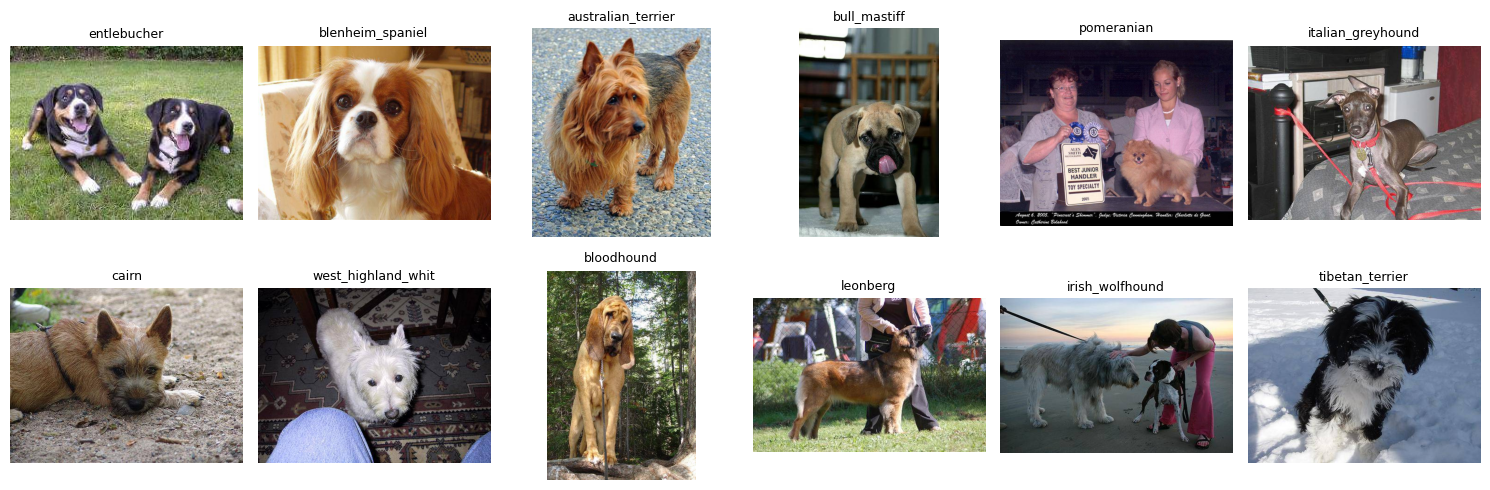

In [15]:
def show_samples(paths, labels_text, n=12, cols=6):
    rows = int(np.ceil(n/cols))
    plt.figure(figsize=(2.5*cols, 2.5*rows))
    for i, idx in enumerate(random.sample(range(len(paths)), k=min(n, len(paths)))):
        try:
            img = Image.open(paths[idx]).convert('RGB')
            plt.subplot(rows, cols, i+1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(str(labels_text[idx])[:18], fontsize=9)
        except:
            continue
    plt.tight_layout()
    plt.show()

# Used original string labels for easier readablity 
show_samples(filenames, labels['breed'].tolist(), n=12, cols=6)


# Feature Engineering

In [23]:

labels_path = '/kaggle/input/dog-breed-identification/labels.csv'
image_dir = '/kaggle/input/dog-breed-identification/train/'

labels = pd.read_csv(labels_path)
filenames = [os.path.join(image_dir, f"{fname}.jpg") for fname in labels['id']]

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels['breed'])


onehot_encoder = OneHotEncoder(sparse_output=False)
y_onehot = onehot_encoder.fit_transform(labels[['breed']])

IMG_SIZE = 224

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),       # Resize images
    transforms.ToTensor(),                         # Convert to tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5],     # Normalize to [-1, 1]
                         std=[0.5, 0.5, 0.5])
])

class DogBreedDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image and apply transform
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Get encoded label
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return image, label


dataset = DogBreedDataset(filenames, y_encoded, transform)

print(f"Total samples: {len(dataset)}")
print(f"Number of classes: {len(label_encoder.classes_)}")
print("Feature engineering complete ")


Total samples: 10222
Number of classes: 120
Feature engineering complete 
